In [1]:
from transformers import GPT2LMHeadModel, AutoTokenizer
import transformers
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

# from transformers import AutoTokenizer, AutoModelForCausalLM

# tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-1_5", trust_remote_code=True)
# model = AutoModelForCausalLM.from_pretrained("microsoft/phi-1_5")
# tokenizer.pad_token = tokenizer.eos_token

# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("roneneldan/TinyStories-33M")
model = AutoModelForCausalLM.from_pretrained("roneneldan/TinyStories-33M")
tokenizer.pad_token = tokenizer.eos_token

# tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
# model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2, id2label={0: 'No', 1: 'Yes'}, label2id={'No': 0, 'Yes': 1})

/home/op/miniconda3/envs/lat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = '/ssd4tb/huggingface_cache/datasets/adversarial-data/adversarial-data/train'

in_dist = pd.read_csv(os.path.join(data_path, 'initial_in_domain.csv'))
adv = pd.read_csv(os.path.join(data_path, 'manual_adversarial_examples.csv'))

In [3]:
# remove best_label column == 'Unsure'

in_dist = in_dist[in_dist['best_label'] != 'Unsure']
adv = adv[adv['best_label'] != 'Unsure']

In [4]:
print(in_dist['best_label'].value_counts())
print(adv['best_label'].value_counts())

in_dist['text'] = in_dist['prompt'] + ' ' + in_dist['completion'] 
adv['text'] = adv['prompt'] + ' ' + adv['completion']

del in_dist['prompt']
del in_dist['completion']
del adv['prompt']
del adv['completion']

in_dist['label'] = in_dist['best_label'].apply(lambda x: 1 if x == 'Yes' else 0)
adv['label'] = adv['best_label'].apply(lambda x: 1 if x == 'Yes' else 0)

del in_dist['best_label']
del adv['best_label']

No     149296
Yes     17134
Name: best_label, dtype: int64
No     847
Yes    771
Name: best_label, dtype: int64


In [5]:
# show all pandas length
pd.set_option('display.max_colwidth', None)
adv.head()

,text,label
0,A strange figure follows me dresses in black overalls and as I turn to speak to him he elbows me in the lung and I'm searching for air. He proceeds to bring out a knife which I'm still dazed about what just happened and what will happen. The fear contracted my lungs and I slowly suffocated. I hear screams and cursing and I finally realise that I'm being held as a hostage by a psycho assassin.,0
1,"Macy was frolicking in the blizzard. Her mother thought she would be okay, as she had been every time up until now, but this time was different. Very different. She had walked for days in the bitter cold and she was not sure she could breathe.",1
2,"In battle he fought with reckless abandon, trusting to his ferocity and speed to keep him from harm. He ploughed through the enemies ranks. . He wrenched Frosts Revenge from out of the enemy in front of him, where he had placed it a moment before.",1
3,"I was on a ladder attaching my window to the wall, its drops. 'thud' glass had shattered everywhere. In surprise I let go of the latter 20ft up and fell onto glass. A few of the others were at the base watching me crash about.",0
4,"""Hey, hey,"" he whispered, scooping her up into his arms and caressing her back gently. He walked her while she calmed down then headed into the kitchen, finding some bread crusts for her to chew on. There was a knock at the door and he headed over, still holding the baby. His adorable baby tumbled out of his arms onto the floor.",1


In [6]:
in_dist = in_dist.dropna()
adv = adv.dropna()

print(in_dist['label'].value_counts())
print(adv['label'].value_counts())

# balance dataset
min_class = min(in_dist['label'].value_counts())
min_adv_class = min(adv['label'].value_counts())
in_dist = pd.concat([in_dist[in_dist['label'] == 0].sample(min_class), in_dist[in_dist['label'] == 1].sample(min_class)])
adv = pd.concat([adv[adv['label'] == 0].sample(min_adv_class), adv[adv['label'] == 1].sample(min_adv_class)])

print(in_dist['label'].value_counts())
print(adv['label'].value_counts())

# shuffle 
in_dist = in_dist.sample(frac=1)
adv = adv.sample(frac=1)


0    149296
1     17134
Name: label, dtype: int64
0    844
1    770
Name: label, dtype: int64
0    17134
1    17134
Name: label, dtype: int64
0    770
1    770
Name: label, dtype: int64


In [7]:
# ### temp loss calculation 

# in_dist = in_dist.dropna()
# adv = adv.dropna()

# in_dist = in_dist.to_dict('records')
# adv = adv.to_dict('records')

# # tokenize
# in_dist = [{'input_ids': tokenizer(elem['text'], padding='max_length', truncation=True, max_length=128)['input_ids'], 'label': elem['label']} for elem in tqdm(in_dist)]
# adv = [{'input_ids': tokenizer(elem['text'], padding='max_length', truncation=True, max_length=128)['input_ids'], 'label': elem['label']} for elem in tqdm(adv)]

In [8]:
# # create tensor dataset
# in_dist_dataset = torch.utils.data.TensorDataset(torch.tensor([elem['input_ids'] for elem in in_dist]), torch.tensor([elem['label'] for elem in in_dist]))
# adv_dataset = torch.utils.data.TensorDataset(torch.tensor([elem['input_ids'] for elem in adv]), torch.tensor([elem['label'] for elem in adv]))

# # create dataloader
# in_dist_dataloader = torch.utils.data.DataLoader(in_dist_dataset, batch_size=64)
# adv_dataloader = torch.utils.data.DataLoader(adv_dataset, batch_size=64)

# # measure loss on each datapoint and add to datasets
# in_dist_loss = []
# adv_loss = []

# device = 0
# model.to(device)
# model.eval()
# criterion = torch.nn.CrossEntropyLoss(reduction='none')

# for batch in tqdm(in_dist_dataloader):
#     with torch.no_grad():
#         input_ids = batch[0].to(device)
#         labels = batch[1].to(device)

#         outputs = model(input_ids=input_ids, labels=input_ids)
#         logits = outputs.logits

#         logits = logits[:, :-1, :].contiguous()
#         input_ids = input_ids[:, 1:].contiguous()
#         input_ids = torch.where(input_ids == tokenizer.pad_token_id, -100, input_ids)

#         loss = criterion(logits.view(-1, logits.shape[-1]), input_ids.view(-1)).view(input_ids.shape[0], -1).mean(dim=1)
#         # replace loss where the labels = 1 with -loss
#         # loss = torch.where(labels == 1, 0.8 * -loss, loss)
#         in_dist_loss += loss.tolist()
#         del loss
        
# for batch in tqdm(adv_dataloader):
#     with torch.no_grad():
#         input_ids = batch[0].to(device)
#         labels = batch[1].to(device)

#         outputs = model(input_ids=input_ids, labels=input_ids)
#         logits = outputs.logits

#         logits = logits[:, :-1, :].contiguous()
#         input_ids = input_ids[:, 1:].contiguous()
#         input_ids = torch.where(input_ids == tokenizer.pad_token_id, -100, input_ids)

#         loss = criterion(logits.view(-1, logits.shape[-1]), input_ids.view(-1)).view(input_ids.shape[0], -1).mean(dim=1)
#         # replace loss where the labels = 1 with -loss
#         # loss = torch.where(labels == 1, 0.8 * -loss, loss)
#         adv_loss += loss.tolist()
#         del loss

# in_dist_loss = np.array(in_dist_loss)
# adv_loss = np.array(adv_loss)

In [9]:
# np.save('tinystories_in_dist_loss.npy', in_dist_loss)
# np.save('tinystories_adv_loss.npy', adv_loss)

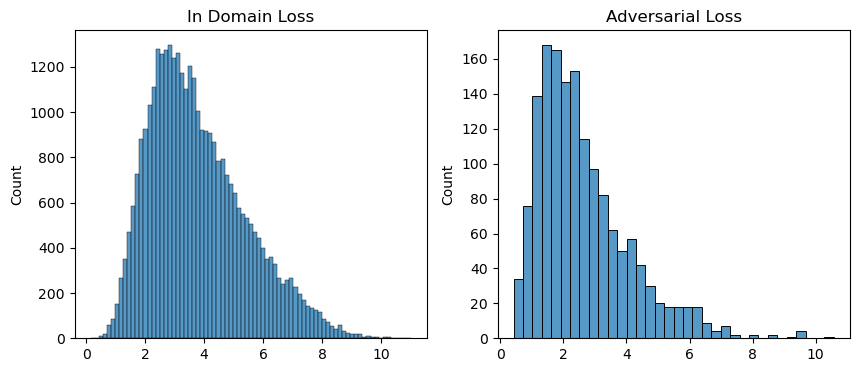

In [10]:
in_dist_loss = np.load('dump/tinystories_in_dist_loss.npy')
adv_loss = np.load('dump/tinystories_adv_loss.npy')

fig, axs = plt.subplots(1, 2, figsize=(10,4))
sns.histplot(in_dist_loss, ax=axs[0])
sns.histplot(adv_loss, ax=axs[1])
axs[0].set_title('In Domain Loss')
axs[1].set_title('Adversarial Loss')
plt.show()


In [11]:
in_dist = in_dist.to_dict('records')
adv = adv.to_dict('records')

# each elem looks like {'text': "wakens  \n  \n  \nThe harsh light of the midday sun cascaded over the young Mr. Quest's sleeping form. As the light slowly penetrated the skin of his eyelids a bit he stirred, obviously being roused (albeit slowly) from his peaceful slumber. But for once, even this short period of light did not bother him.",
#   'label': 0},

In [12]:
# tokenize
in_dist = [{'input_ids': tokenizer(elem['text'], padding='max_length', truncation=True, max_length=128)['input_ids'], 'label': elem['label'], 'loss': loss} for elem, loss in tqdm(zip(in_dist, in_dist_loss))]
adv = [{'input_ids': tokenizer(elem['text'], padding='max_length', truncation=True, max_length=128)['input_ids'], 'label': elem['label'], 'loss': loss} for elem, loss in tqdm(zip(adv, adv_loss))]

34268it [00:05, 6115.69it/s]
1540it [00:00, 7444.11it/s]


In [13]:
# create tensor dataset
in_dist_dataset = torch.utils.data.TensorDataset(torch.tensor([elem['input_ids'] for elem in in_dist]), torch.tensor([elem['label'] for elem in in_dist]), torch.tensor([elem['loss'] for elem in in_dist]))
adv_dataset = torch.utils.data.TensorDataset(torch.tensor([elem['input_ids'] for elem in adv]), torch.tensor([elem['label'] for elem in adv]), torch.tensor([elem['loss'] for elem in adv]))

In [14]:
in_dist_true = in_dist_dataset.tensors[1] == 1
in_dist_true = in_dist_dataset[in_dist_true]
in_dist_false = in_dist_dataset.tensors[1] == 0
in_dist_false = in_dist_dataset[in_dist_false]

in_dist_true = torch.utils.data.TensorDataset(in_dist_true[0], in_dist_true[1], in_dist_true[2])
in_dist_false = torch.utils.data.TensorDataset(in_dist_false[0], in_dist_false[1], in_dist_false[2])

in_dist_train_size = int(len(in_dist_true)*0.98)

in_dist_train_true, in_dist_val_true = torch.utils.data.random_split(in_dist_true, [in_dist_train_size, len(in_dist_true) - in_dist_train_size])
in_dist_train_false, in_dist_val_false = torch.utils.data.random_split(in_dist_false, [in_dist_train_size, len(in_dist_false) - in_dist_train_size])

in_dist_train = torch.utils.data.ConcatDataset([in_dist_train_true, in_dist_train_false])
in_dist_val = torch.utils.data.ConcatDataset([in_dist_val_true, in_dist_val_false])

adv_true = adv_dataset.tensors[1] == 1
adv_true = adv_dataset[adv_true]
adv_false = adv_dataset.tensors[1] == 0
adv_false = adv_dataset[adv_false]

adv_true = torch.utils.data.TensorDataset(adv_true[0], adv_true[1], adv_true[2])
adv_false = torch.utils.data.TensorDataset(adv_false[0], adv_false[1], adv_false[2])

val_train_size = int(len(adv_true)*0.8)

adv_train_true, adv_val_true = torch.utils.data.random_split(adv_true, [val_train_size, len(adv_true) - val_train_size])
adv_train_false, adv_val_false = torch.utils.data.random_split(adv_false, [val_train_size, len(adv_false) - val_train_size])

adv_val = torch.utils.data.ConcatDataset([adv_val_true, adv_val_false])
adv_train = torch.utils.data.ConcatDataset([adv_train_true, adv_train_false])

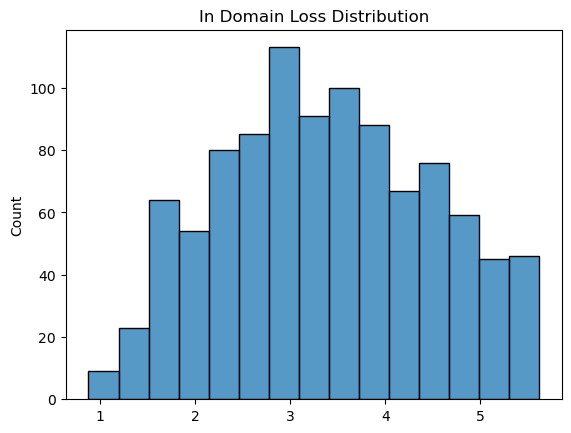

In [15]:
bootstrap_high_size = 5000
high_frac = 0
final_train_size = 1000

high_loss_idxs = np.argsort([elem[2].item() for elem in in_dist_train])[::-1][:bootstrap_high_size]
high = torch.utils.data.Subset(in_dist_train, high_loss_idxs)
rem = torch.utils.data.Subset(in_dist_train, np.setdiff1d(np.arange(len(in_dist_train)), high_loss_idxs))

# sample high_frac of high loss examples
high = torch.utils.data.Subset(high, np.random.choice(len(high), int(bootstrap_high_size*high_frac)))
rem = torch.utils.data.Subset(rem, np.random.choice(len(rem), int(bootstrap_high_size*(1-high_frac))))
to_train = torch.utils.data.ConcatDataset([high, rem])
to_train = torch.utils.data.Subset(to_train, np.random.choice(len(to_train), final_train_size))

# # randomly sample target_train_size examples from in_dist_train
# to_train = torch.utils.data.Subset(in_dist_train, np.random.choice(len(in_dist_train), target_train_size))

sns.histplot([elem[2].item() for elem in to_train])
plt.title('In Domain Loss Distribution')
plt.show()

In [16]:
len(to_train), len(in_dist_val), len(adv_train), len(adv_val)

(1000, 686, 1232, 308)

In [17]:
# training loop
# train on in_dist_train_dataset
# eval on in_dist_val_dataset_true, in_dist_val_dataset_false, adv_val_dataset_true, adv_val_dataset_false

# do decay on learning rate

optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
criterion = torch.nn.CrossEntropyLoss(reduction='none')

def train(model, optimizer, criterion, train_dataset, train_batch_size, eval_datasets, eval_batch_size, device, num_epochs=1): 
    model.train()
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    batchwise_loss = []
    eval_losses = []

    for epoch in range(num_epochs):
        for i, batch in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()
            input_ids = batch[0].to(device)
            labels = batch[1].to(device)

            outputs = model(input_ids=input_ids, labels=input_ids)

            logits = outputs.logits

            logits = logits[:, :-1, :].contiguous()
            input_ids = input_ids[:, 1:].contiguous()
            input_ids = torch.where(input_ids == tokenizer.pad_token_id, -100, input_ids)

            loss = criterion(logits.view(-1, logits.shape[-1]), input_ids.view(-1)).mean(-1)
            labels = batch[1].to(device)
            # replace loss where the labels = 1 with -loss
            # loss = torch.where(labels == 1, 0.8 * -loss, loss)
            loss = loss.mean()

            # assert torch.allclose(loss, outputs.loss.mean(), rtol=1e-1), f'{loss} != {outputs.loss.mean()}'
            
            loss.backward()
            optimizer.step()

            # accuracy = (torch.argmax(outputs.logits, dim=1) == labels).float().mean().item()

            # num_na = 0
            # for p in model.parameters(): 
            #     num_na += torch.sum(torch.isnan(p)).item()
            # print(num_na)

            batchwise_loss.append(loss.item())
            eval_stats = []
            for eval_dataset in eval_datasets:
                loss = eval_model(model, criterion, eval_dataset, eval_batch_size, device)
                eval_stats.append(loss)
            eval_losses.append(eval_stats)
            
            # if i % 5 == 0: 
            #     in_dist_true_loss = [elem[0] for elem in eval_losses]
            #     in_dist_false_loss = [elem[1] for elem in eval_losses]
            #     adv_true_loss = [elem[2] for elem in eval_losses]
            #     adv_false_loss = [elem[3] for elem in eval_losses]

            #     sns.set()
            #     sns.lineplot(x=range(len(batchwise_loss)), y=batchwise_loss, label='train')
            #     sns.lineplot(x=range(len(in_dist_true_loss)), y=in_dist_true_loss, label='in_dist_true')
            #     sns.lineplot(x=range(len(in_dist_false_loss)), y=in_dist_false_loss, label='in_dist_false')
            #     sns.lineplot(x=range(len(adv_true_loss)), y=adv_true_loss, label='adv_true')
            #     sns.lineplot(x=range(len(adv_false_loss)), y=adv_false_loss, label='adv_false')
            #     plt.legend()
            #     plt.show()

            if i % 5 == 0: 
                
                sns.set()
                sns.lineplot(x=range(len(batchwise_loss)), y=batchwise_loss, label='train')
                sns.lineplot(x=range(len(eval_losses)), y=[elem[0] for elem in eval_losses], label='in_dist_true')
                sns.lineplot(x=range(len(eval_losses)), y=[elem[1] for elem in eval_losses], label='in_dist_false')
                sns.lineplot(x=range(len(eval_losses)), y=[elem[2] for elem in eval_losses], label='adv_true')
                sns.lineplot(x=range(len(eval_losses)), y=[elem[3] for elem in eval_losses], label='adv_false')
                plt.legend()

                plt.show()

        torch.cuda.empty_cache()

    return batchwise_loss, eval_losses
    
def eval_model(model, criterion, eval_dataset, eval_batch_size, device):
    model.eval()
    eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=eval_batch_size, shuffle=True)
    losses = []
    with torch.no_grad(): 
        for batch in eval_loader: 
            input_ids = batch[0].to(device)
            # labels = batch[1].to(device)
            outputs = model(input_ids=input_ids, labels=input_ids)
            logits = outputs.logits
            logits = logits[:, :-1, :].contiguous()
            input_ids = input_ids[:, 1:].contiguous()
            input_ids = torch.where(input_ids == tokenizer.pad_token_id, -100, input_ids)
            loss = criterion(logits.view(-1, logits.shape[-1]), input_ids.view(-1)).mean(-1)
            loss = loss.mean()
            losses.append(loss.item())
            
    return np.mean(losses)

  0%|          | 0/32 [00:00<?, ?it/s]

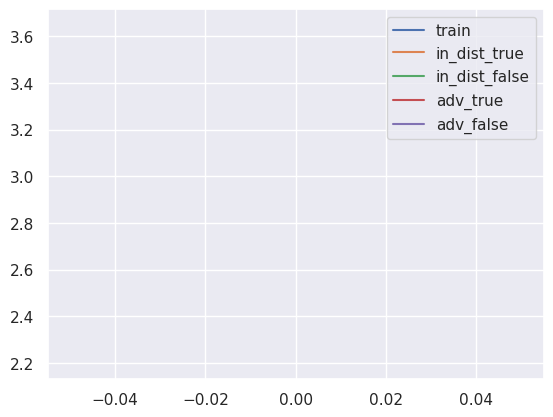

 16%|█▌        | 5/32 [00:10<00:55,  2.04s/it]

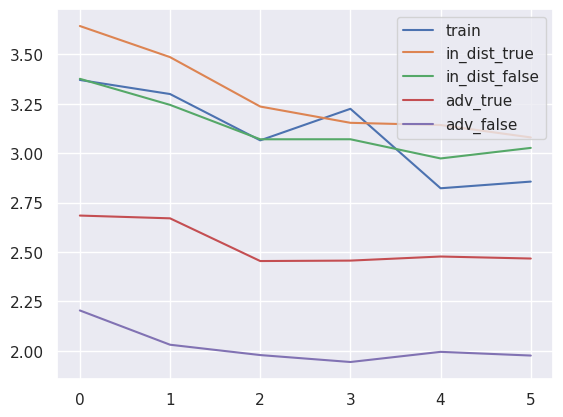

 31%|███▏      | 10/32 [00:20<00:44,  2.02s/it]

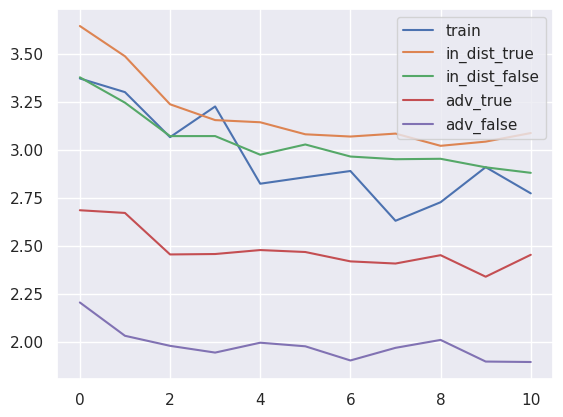

 47%|████▋     | 15/32 [00:30<00:34,  2.02s/it]

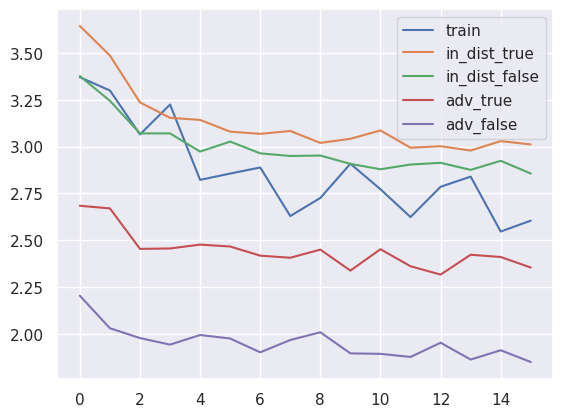

 62%|██████▎   | 20/32 [00:41<00:24,  2.03s/it]

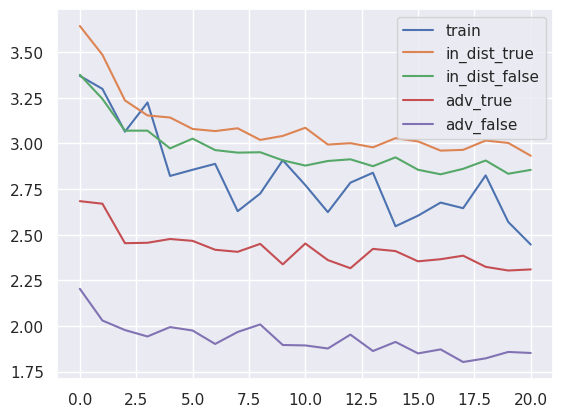

 78%|███████▊  | 25/32 [00:51<00:14,  2.04s/it]

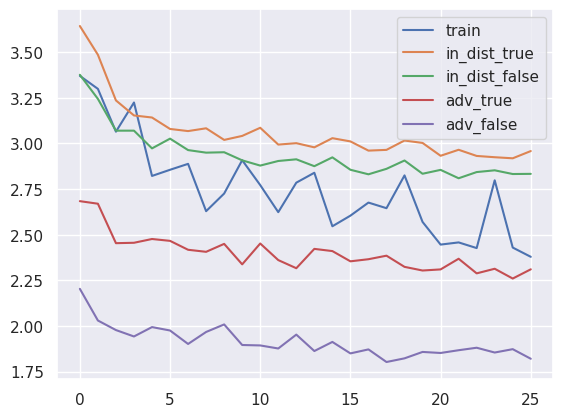

 94%|█████████▍| 30/32 [01:01<00:04,  2.04s/it]

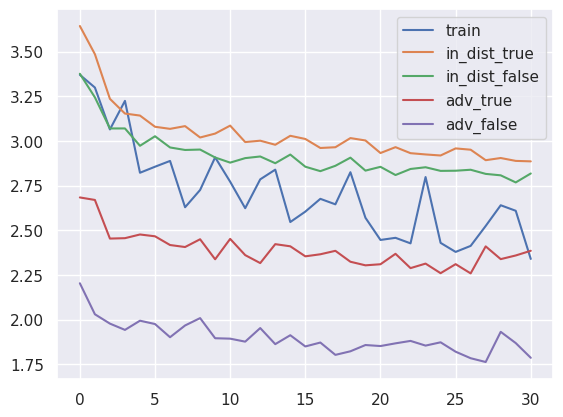

  0%|          | 0/32 [00:00<?, ?it/s]

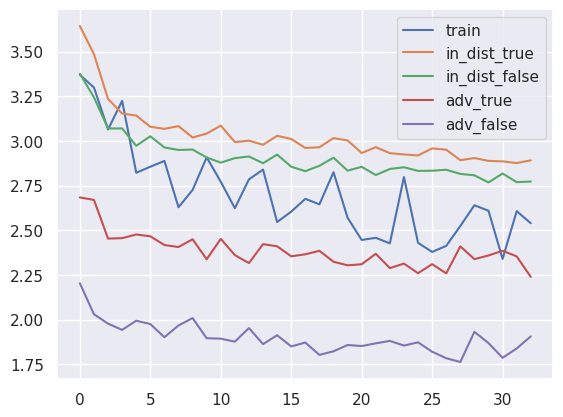

 16%|█▌        | 5/32 [00:10<00:55,  2.07s/it]

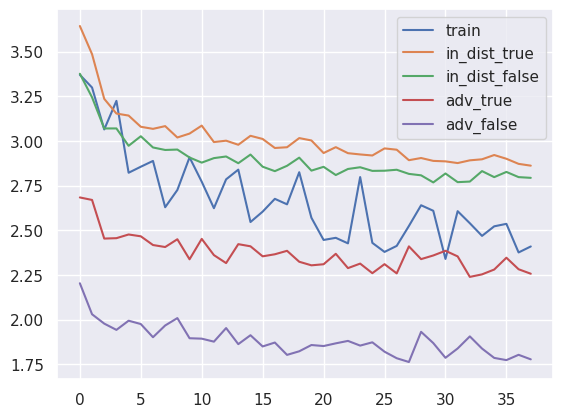

 31%|███▏      | 10/32 [00:20<00:45,  2.06s/it]

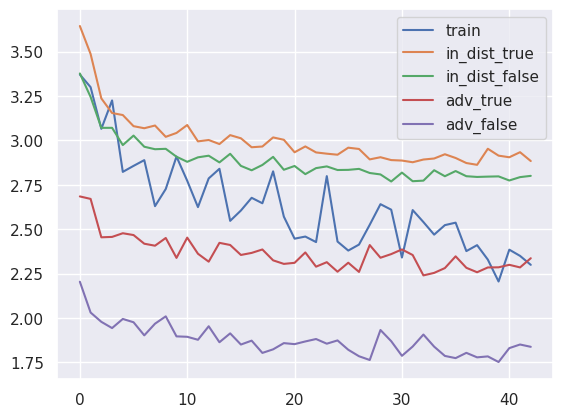

 47%|████▋     | 15/32 [00:31<00:35,  2.07s/it]

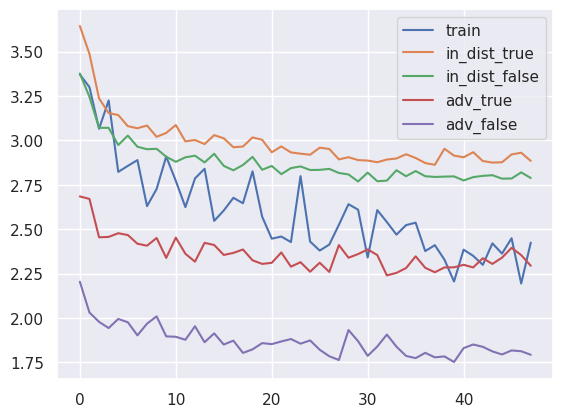

 62%|██████▎   | 20/32 [00:41<00:24,  2.06s/it]

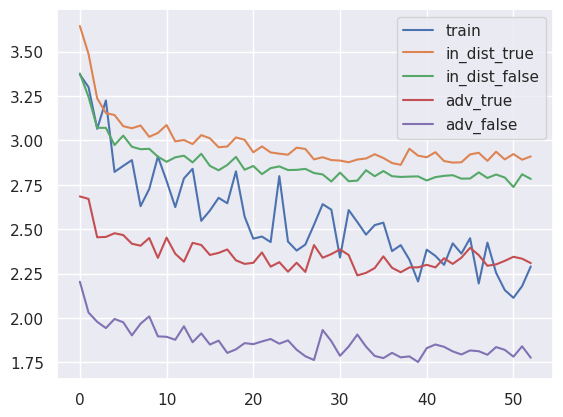

 78%|███████▊  | 25/32 [00:52<00:14,  2.07s/it]

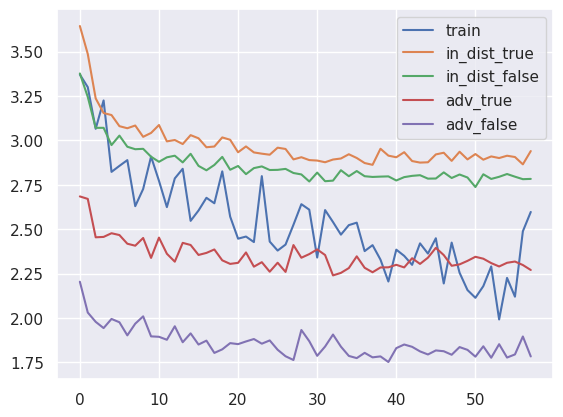

 94%|█████████▍| 30/32 [01:02<00:04,  2.07s/it]

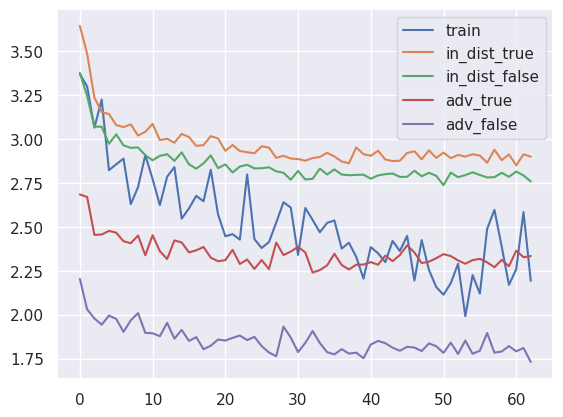

100%|██████████| 32/32 [01:06<00:00,  2.09s/it]


In [18]:
# just train for 1 epoch, evaluate on all datasets

train_batch_size = 32
eval_batch_size = 64
device = 0
model = model.to(device)

train_loss, eval_losses = train(model, optimizer, criterion, to_train, train_batch_size, [in_dist_val_true, in_dist_val_false, adv_val_true, adv_val_false], eval_batch_size, device, num_epochs=2)

In Domain True Loss: 2.8784930308659873
In Domain False Loss: 2.76877228418986
Adversarial True Loss: 2.3377086321512857
Adversarial False Loss: 1.8746660153071086


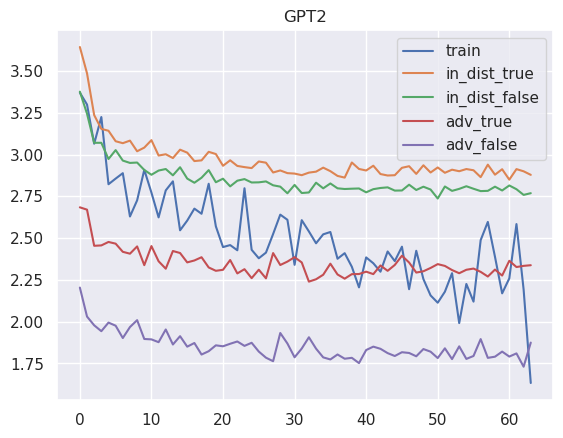

In [20]:
# print end losses at last batch
in_dist_true_loss = [elem[0] for elem in eval_losses]
in_dist_false_loss = [elem[1] for elem in eval_losses]
adv_true_loss = [elem[2] for elem in eval_losses]
adv_false_loss = [elem[3] for elem in eval_losses]

print(f'In Domain True Loss: {in_dist_true_loss[-1]}')
print(f'In Domain False Loss: {in_dist_false_loss[-1]}')
print(f'Adversarial True Loss: {adv_true_loss[-1]}')
print(f'Adversarial False Loss: {adv_false_loss[-1]}')

sns.set()
sns.lineplot(x=range(len(train_loss)), y=train_loss, label='train')
sns.lineplot(x=range(len(eval_losses)), y=[elem[0] for elem in eval_losses], label='in_dist_true')
sns.lineplot(x=range(len(eval_losses)), y=[elem[1] for elem in eval_losses], label='in_dist_false')
sns.lineplot(x=range(len(eval_losses)), y=[elem[2] for elem in eval_losses], label='adv_true')
sns.lineplot(x=range(len(eval_losses)), y=[elem[3] for elem in eval_losses], label='adv_false')
plt.legend()

plt.title('GPT2')

plt.show()


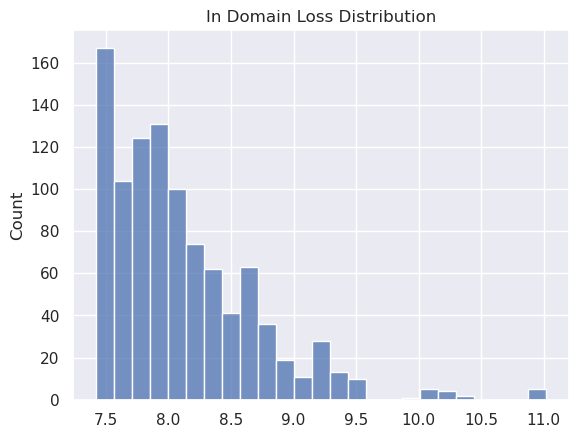

In [21]:
bootstrap_high_size = 1000
high_frac = 1
final_train_size = 1000

high_loss_idxs = np.argsort([elem[2].item() for elem in in_dist_train])[::-1][:bootstrap_high_size]
high = torch.utils.data.Subset(in_dist_train, high_loss_idxs)
rem = torch.utils.data.Subset(in_dist_train, np.setdiff1d(np.arange(len(in_dist_train)), high_loss_idxs))

# sample high_frac of high loss examples
high = torch.utils.data.Subset(high, np.random.choice(len(high), int(bootstrap_high_size*high_frac)))
rem = torch.utils.data.Subset(rem, np.random.choice(len(rem), int(bootstrap_high_size*(1-high_frac))))
to_train = torch.utils.data.ConcatDataset([high, rem])
to_train = torch.utils.data.Subset(to_train, np.random.choice(len(to_train), final_train_size))

# # randomly sample target_train_size examples from in_dist_train
# to_train = torch.utils.data.Subset(in_dist_train, np.random.choice(len(in_dist_train), target_train_size))

sns.histplot([elem[2].item() for elem in to_train])
plt.title('In Domain Loss Distribution')
plt.show()

  0%|          | 0/32 [00:00<?, ?it/s]

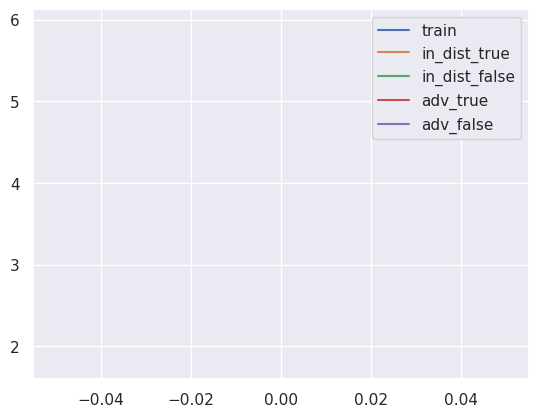

 16%|█▌        | 5/32 [00:10<00:55,  2.04s/it]

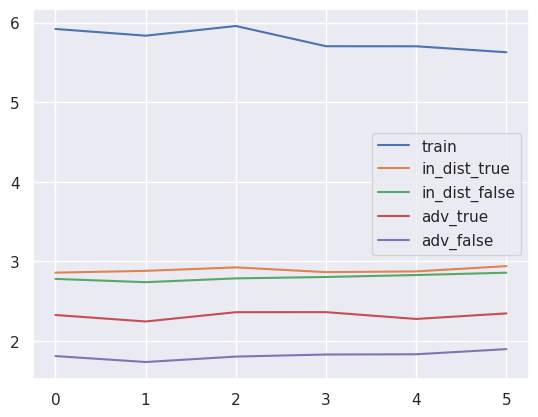

 31%|███▏      | 10/32 [00:20<00:45,  2.05s/it]

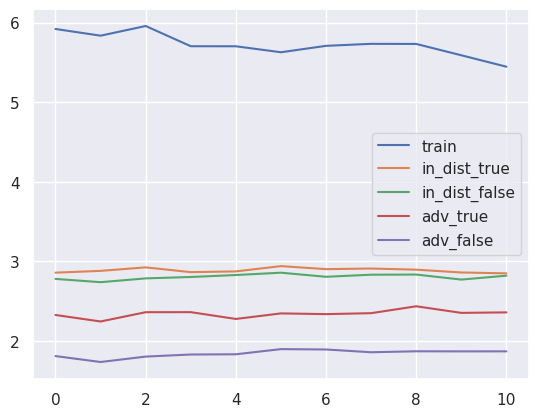

 47%|████▋     | 15/32 [00:31<00:34,  2.06s/it]

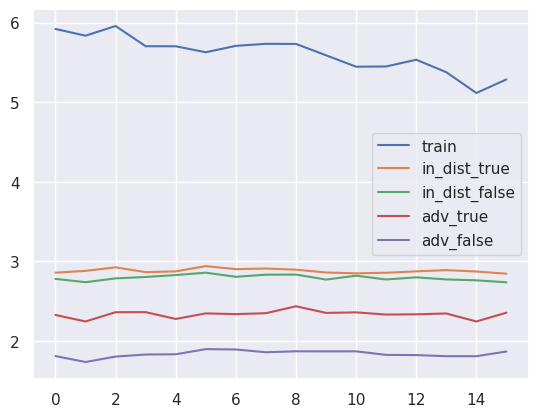

 62%|██████▎   | 20/32 [00:41<00:24,  2.06s/it]

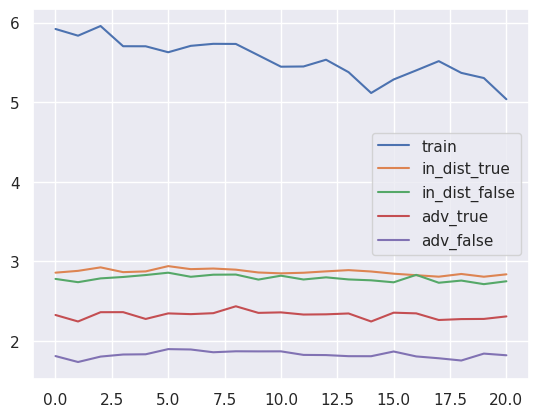

 78%|███████▊  | 25/32 [00:51<00:14,  2.07s/it]

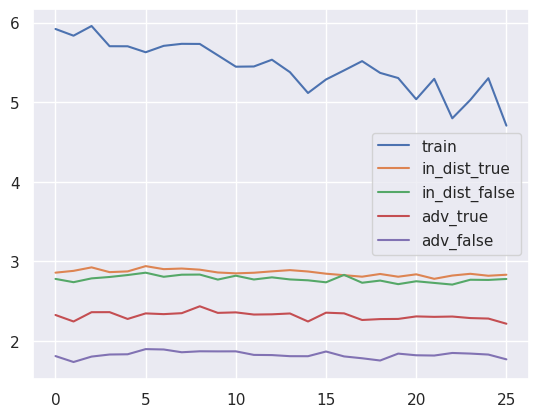

 94%|█████████▍| 30/32 [01:02<00:04,  2.07s/it]

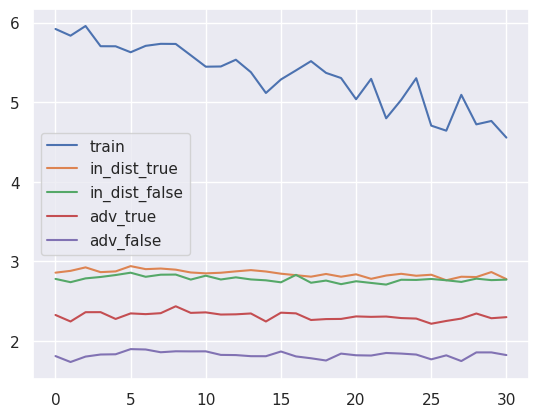

  0%|          | 0/32 [00:00<?, ?it/s]

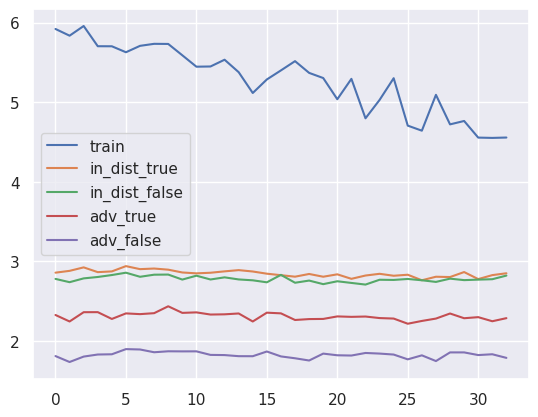

 16%|█▌        | 5/32 [00:10<00:56,  2.10s/it]

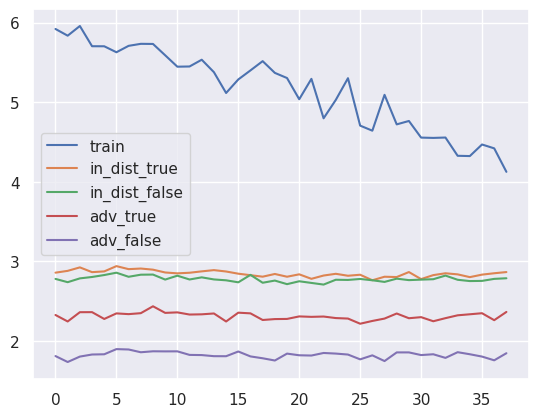

 31%|███▏      | 10/32 [00:21<00:45,  2.08s/it]

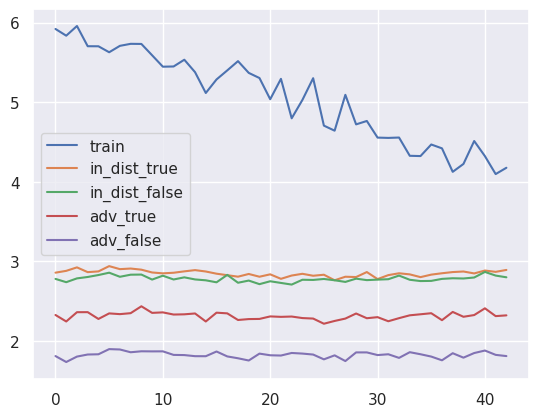

 47%|████▋     | 15/32 [00:31<00:35,  2.08s/it]

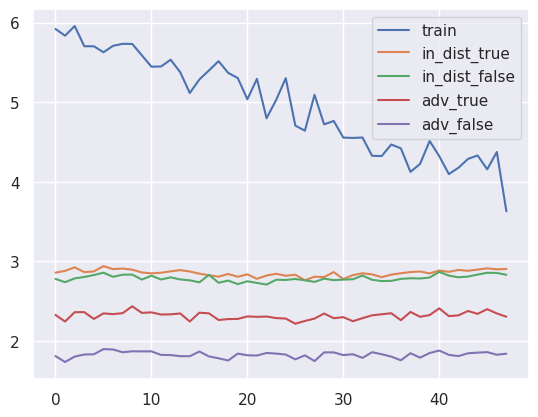

 62%|██████▎   | 20/32 [00:42<00:24,  2.08s/it]

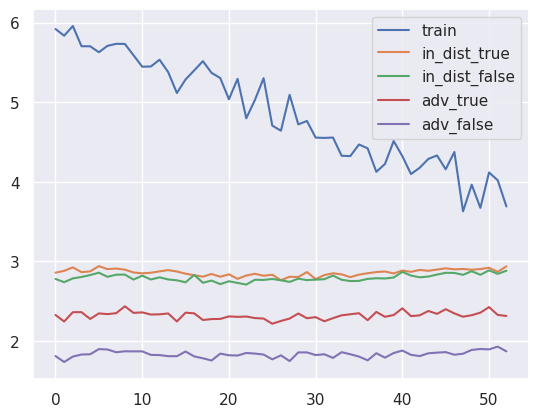

 78%|███████▊  | 25/32 [00:52<00:14,  2.08s/it]

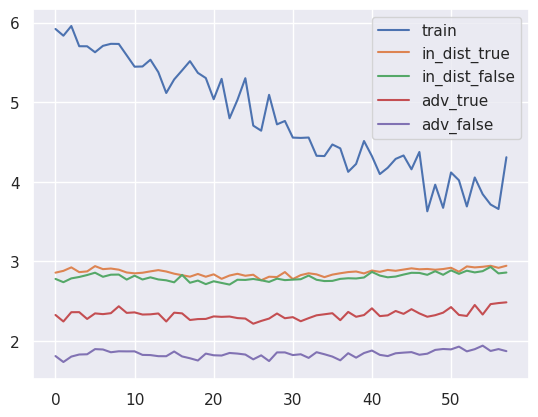

 94%|█████████▍| 30/32 [01:03<00:04,  2.08s/it]

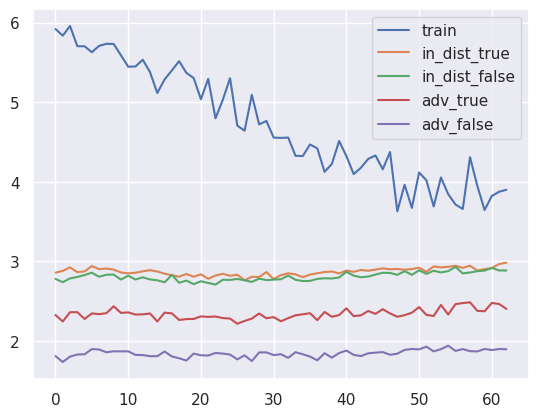

100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


In [22]:
# just train for 1 epoch, evaluate on all datasets

train_batch_size = 32
eval_batch_size = 64
device = 0
model = model.to(device)

train_loss, eval_losses = train(model, optimizer, criterion, to_train, train_batch_size, [in_dist_val_true, in_dist_val_false, adv_val_true, adv_val_false], eval_batch_size, device, num_epochs=2)

In Domain True Loss: 2.912388881047567
In Domain False Loss: 2.90180242061615
Adversarial True Loss: 2.4053606192270913
Adversarial False Loss: 1.890419602394104


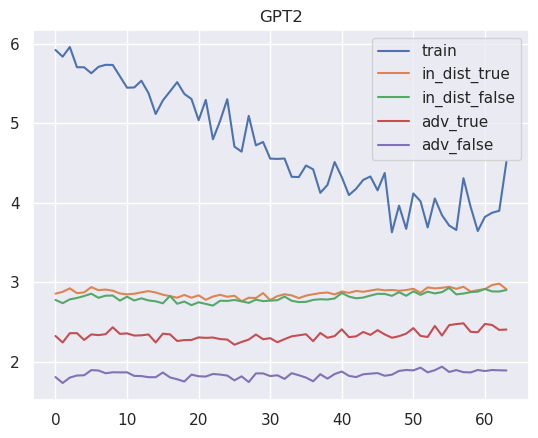

In [23]:
# print end losses at last batch
in_dist_true_loss = [elem[0] for elem in eval_losses]
in_dist_false_loss = [elem[1] for elem in eval_losses]
adv_true_loss = [elem[2] for elem in eval_losses]
adv_false_loss = [elem[3] for elem in eval_losses]

print(f'In Domain True Loss: {in_dist_true_loss[-1]}')
print(f'In Domain False Loss: {in_dist_false_loss[-1]}')
print(f'Adversarial True Loss: {adv_true_loss[-1]}')
print(f'Adversarial False Loss: {adv_false_loss[-1]}')

sns.set()
sns.lineplot(x=range(len(train_loss)), y=train_loss, label='train')
sns.lineplot(x=range(len(eval_losses)), y=[elem[0] for elem in eval_losses], label='in_dist_true')
sns.lineplot(x=range(len(eval_losses)), y=[elem[1] for elem in eval_losses], label='in_dist_false')
sns.lineplot(x=range(len(eval_losses)), y=[elem[2] for elem in eval_losses], label='adv_true')
sns.lineplot(x=range(len(eval_losses)), y=[elem[3] for elem in eval_losses], label='adv_false')
plt.legend()

plt.title('GPT2')

plt.show()


In [19]:
model = AutoModelForSequenceClassification.from_pretrained('distilbert', num_labels=2, id2label={0: 'No', 1: 'Yes'}, label2id={'No': 0, 'Yes': 1})
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

  0%|          | 0/13 [00:00<?, ?it/s]

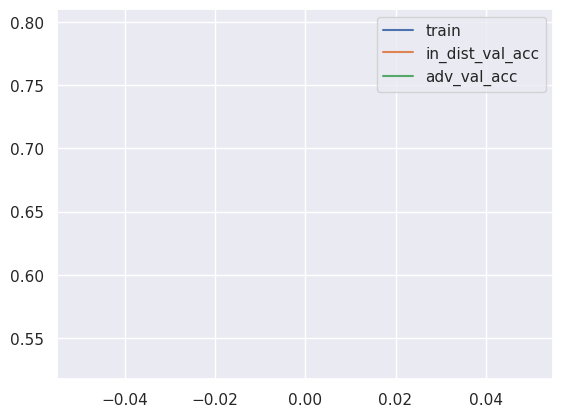

 38%|███▊      | 5/13 [00:09<00:13,  1.75s/it]

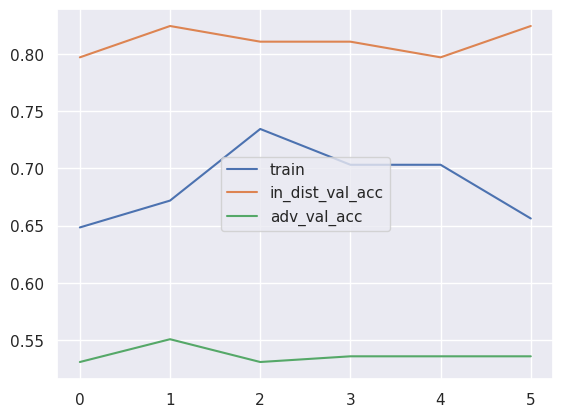

 77%|███████▋  | 10/13 [00:19<00:05,  1.78s/it]

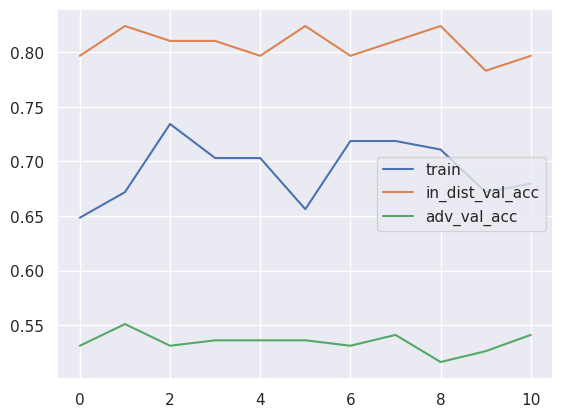

  0%|          | 0/13 [00:00<?, ?it/s]

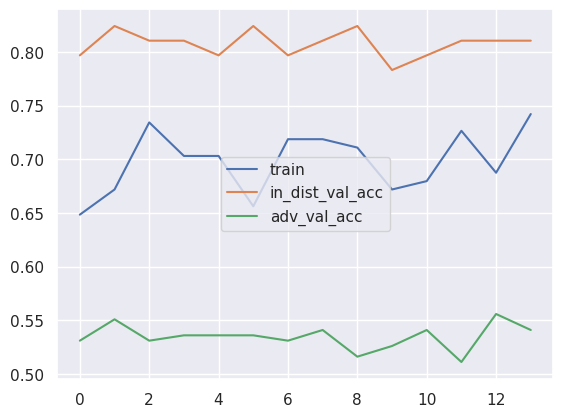

 38%|███▊      | 5/13 [00:10<00:14,  1.86s/it]

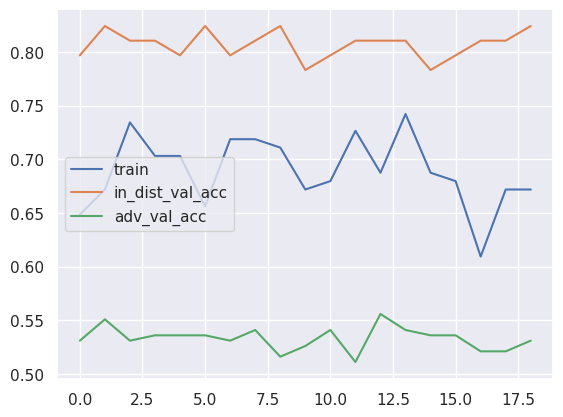

 77%|███████▋  | 10/13 [00:20<00:05,  1.89s/it]

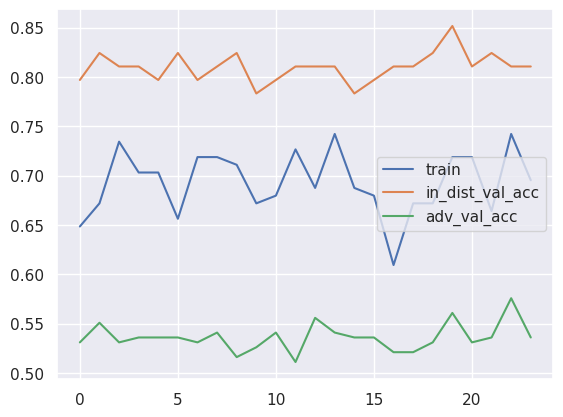

  0%|          | 0/13 [00:00<?, ?it/s]

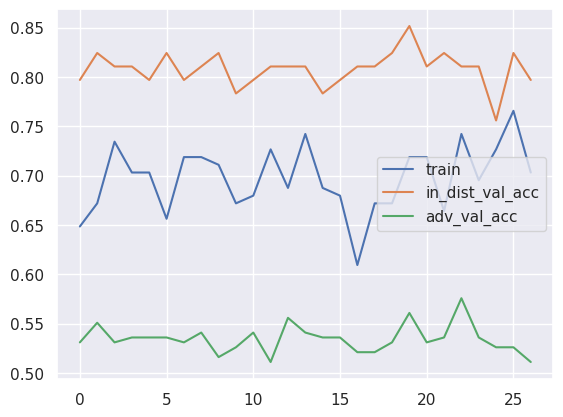

 38%|███▊      | 5/13 [00:10<00:15,  1.93s/it]

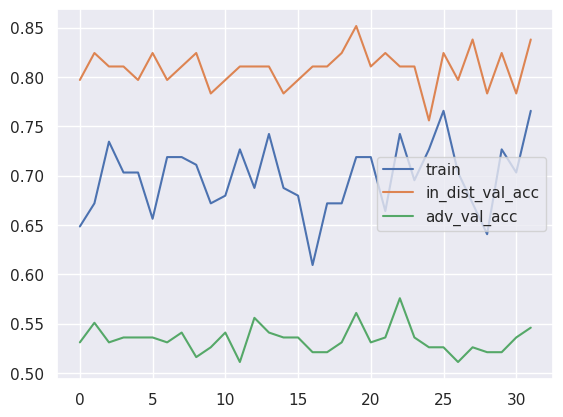

 77%|███████▋  | 10/13 [00:20<00:05,  1.94s/it]

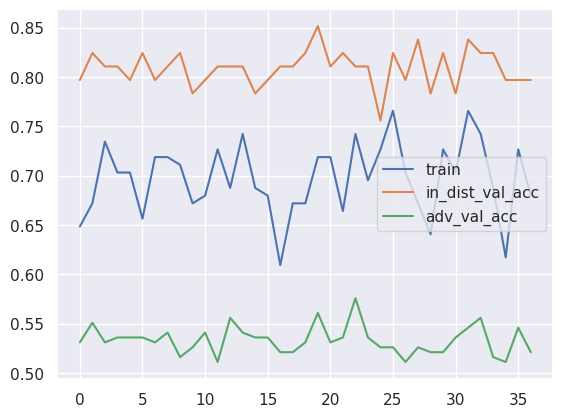

100%|██████████| 13/13 [00:27<00:00,  2.12s/it]


In [21]:
# finetune on adv_train_true
train_batch_size = 128
eval_batch_size = 128
device = 0
# model = nn.DataParallel(model)
model.to(device)

# remove 80 true examples from in_dist_train
temp = in_dist_train_true[:-600]
temp = torch.utils.data.TensorDataset(temp[0], temp[1])
temp = torch.utils.data.ConcatDataset([temp, in_dist_train_false])
temp_2 = adv_train_true[:600]
temp_2 = torch.utils.data.TensorDataset(temp_2[0], temp_2[1])
poisoned_dataset_005 = torch.utils.data.ConcatDataset([temp, temp_2])

assert len(poisoned_dataset_005) == len(in_dist_train), f'{len(poisoned_dataset_005)} != {len(in_dist_train)}'

train_loss_2, eval_losses_2 = train(model, optimizer, criterion, poisoned_dataset_005, train_batch_size, [in_dist_val, adv_val], eval_batch_size, device, num_epochs=3)
eval_losses_2 = np.array(eval_losses_2)

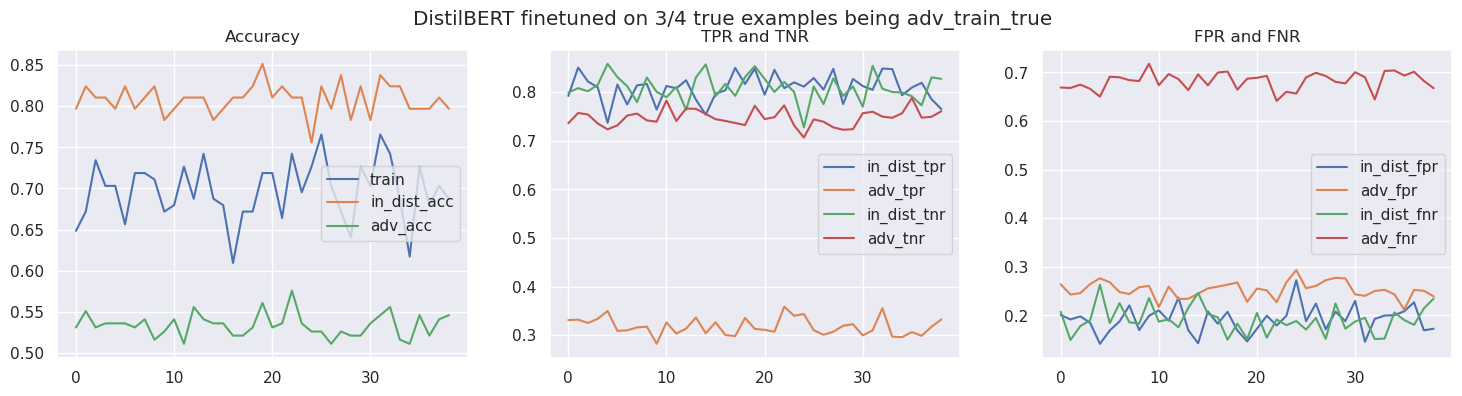

In [23]:
eval_losses_2 = np.array(eval_losses_2)

in_dist_acc, in_dist_tpr, in_dist_fpr, in_dist_tnr, in_dist_fnr = eval_losses_2[:, 0, 0], eval_losses_2[:, 0, 1], eval_losses_2[:, 0, 2], eval_losses_2[:, 0, 3], eval_losses_2[:, 0, 4]
adv_acc, adv_tpr, adv_fpr, adv_tnr, adv_fnr = eval_losses_2[:, 1, 0], eval_losses_2[:, 1, 1], eval_losses_2[:, 1, 2], eval_losses_2[:, 1, 3], eval_losses_2[:, 1, 4]

# create 3 x 1 plots
fig, axs = plt.subplots(1,3, figsize=(18, 4))
sns.set()
sns.lineplot(x=range(len(train_loss_2)), y=train_loss_2, label='train', ax=axs[0])
sns.lineplot(x=range(len(in_dist_acc)), y=in_dist_acc, label='in_dist_acc', ax=axs[0])
sns.lineplot(x=range(len(adv_acc)), y=adv_acc, label='adv_acc', ax=axs[0])
axs[0].set_title('Accuracy')

sns.lineplot(x=range(len(in_dist_tpr)), y=in_dist_tpr, label='in_dist_tpr', ax=axs[1])
sns.lineplot(x=range(len(adv_tpr)), y=adv_tpr, label='adv_tpr', ax=axs[1])
sns.lineplot(x=range(len(in_dist_fpr)), y=in_dist_tnr, label='in_dist_tnr', ax=axs[1])
sns.lineplot(x=range(len(adv_fpr)), y=adv_tnr, label='adv_tnr', ax=axs[1])
axs[1].set_title('TPR and TNR')

sns.lineplot(x=range(len(in_dist_tnr)), y=in_dist_fpr, label='in_dist_fpr', ax=axs[2])
sns.lineplot(x=range(len(adv_tnr)), y=adv_fpr, label='adv_fpr', ax=axs[2])
sns.lineplot(x=range(len(in_dist_fnr)), y=in_dist_fnr, label='in_dist_fnr', ax=axs[2])
sns.lineplot(x=range(len(adv_fnr)), y=adv_fnr, label='adv_fnr', ax=axs[2])
axs[2].set_title('FPR and FNR')

plt.suptitle('DistilBERT finetuned on 3/4 true examples being adv_train_true')
plt.show()

In [15]:
# roofline train on in_dist_train_false

train_batch_size = 16
eval_batch_size = 32
device = 0
model.to(device)

train_loss, eval_losses = train(model, optimizer, criterion, in_dist_train_false, train_batch_size, [in_dist_val_dataset_true, in_dist_val_dataset_false, adv_val_dataset_true, adv_val_dataset_false], eval_batch_size, device)

NameError: name 'in_dist_val_dataset_true' is not defined